In [4]:
import torch
import torch.nn as nn

In [23]:
class Biasneck(nn.Module):
    expanxion = 1
    
    def __init__(self,in_channel, out_channel,stride=1,downsample=None):
        super(Biasneck,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel,out_channels=out_channel,stride=stride,kernel_size=3,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=in_channel,out_channels=out_channel,stride=stride,kernel_size=3,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample =downsample
        self.relu2 = nn.ReLU()
    def forward(self,x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out = out + identity
        out = self.relu2(out)
        return out
        

In [24]:
model = Biasneck(64,64)

In [15]:
import torchvision.transforms as transformer

trans = transformer.Compose([transformer.Resize((224,224)),transformer.ToTensor()])

In [16]:
from matplotlib import pyplot as plt
from PIL import Image

img_path = './img/dog.png'
img = Image.open(img_path)
img_tensor = trans(img)

In [17]:
img_tensor.shape

torch.Size([3, 224, 224])

In [18]:
conv1_1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7,stride=2,padding=3)
out1 = conv1_1(img_tensor)
print(out1.shape)

torch.Size([64, 112, 112])


In [20]:
max_pool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
out2 = max_pool(out1)
print(out2.shape)

torch.Size([64, 56, 56])


In [25]:
out3 = out2.resize(1,64,56,56)
out4 = model(out3)
print(out4.shape)

torch.Size([1, 64, 56, 56])


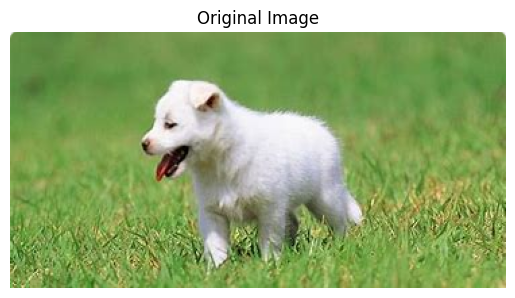

In [31]:
plt.title("Original Image")
plt.axis('off')
plt.imshow(img)
plt.show()
fig,axs = plt.subplots(8,8,figsize=(224,224))
# 显示卷积后的输出
for i in range(8):
    for j in range(8):
     # plt.subplot(8, 8, i+1)
        axs[i,j].set_title(f'Image {i * 3 + j + 1}')
        axs[i,j].imshow(out4.detach().numpy()[0, (8*i)+j, :, :])  # 可视化卷积输出的第一个通道
        axs[i,j].axis('off')
plt.show()

In [32]:
out5 = model(out4)
print(out5.shape)

torch.Size([1, 64, 56, 56])


In [34]:
conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1)
out6 = conv2(out5)
print(out6.shape)

torch.Size([1, 128, 28, 28])


In [35]:
model1 = Biasneck(128,128)
out7 = model1(out6)
out8 = model1(out7)
print(out8.shape)

torch.Size([1, 128, 28, 28])


In [37]:
conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=2,padding=1)
out9 = conv3(out8)
print(out9.shape)

torch.Size([1, 256, 14, 14])


In [38]:
model2 = Biasneck(256,256)
out10 = model2(out9)
out11 = model2(out10)
print(out11.shape)

torch.Size([1, 256, 14, 14])


In [39]:
conv4 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=2,padding=1)
out12 = conv4(out11)
print(out12.shape)

torch.Size([1, 512, 7, 7])


In [40]:
model2 = Biasneck(512,512)
out13 = model2(out12)
out14 = model2(out13)
print(out14.shape)

torch.Size([1, 512, 7, 7])


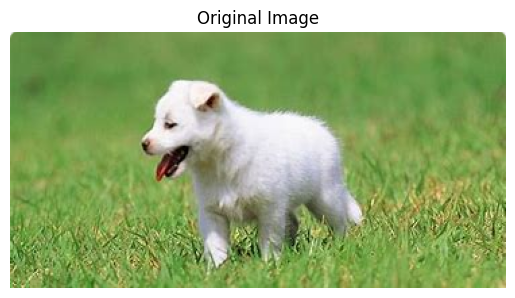

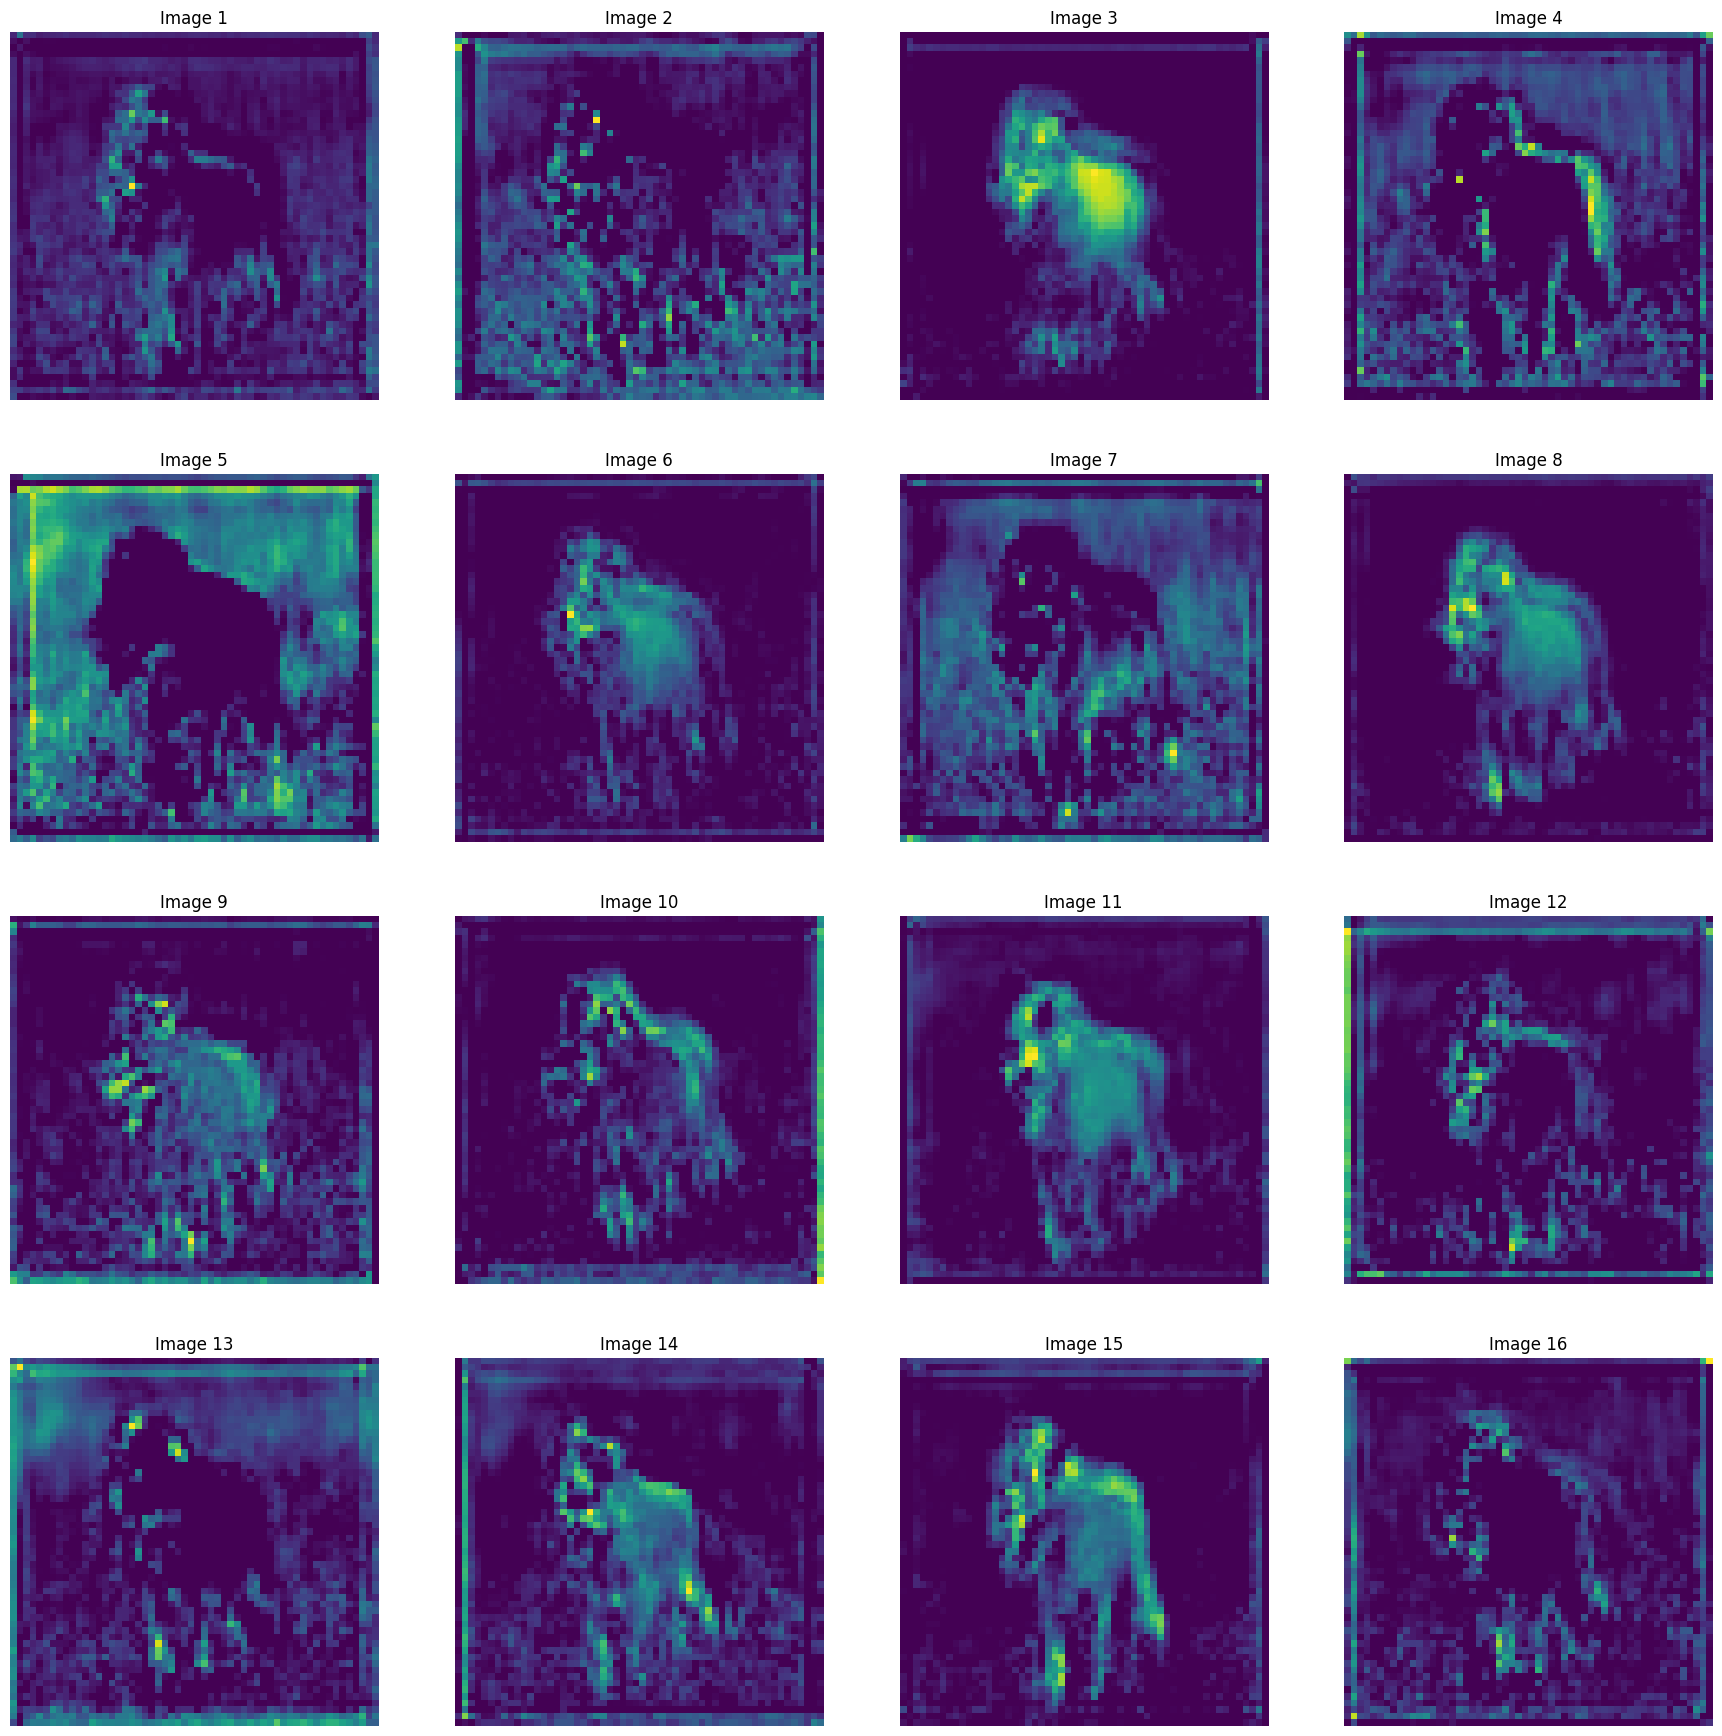

In [44]:
plt.title("Original Image")
plt.axis('off')
plt.imshow(img)
plt.show()
fig,axs = plt.subplots(4,4,figsize=(22,22))
# 显示卷积后的输出
for i in range(4):
    for j in range(4):
     # plt.subplot(8, 8, i+1)
        axs[i,j].set_title(f'Image {i * 4 + j + 1}')
        axs[i,j].imshow(out5.detach().numpy()[0, (4*i)+j, :, :])  # 可视化卷积输出的第一个通道
        axs[i,j].axis('off')
plt.show()

In [45]:
class Bottleneck(nn.Module):
    expansive = 4
    def __init__(self,in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel,out_channels=out_channel,kernel_size=1,stride=stride,bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        
        self.conv2 = nn.Conv2d(in_channels=out_channel,out_channels=out_channel,kernel_size=3,stride=stride,bias=False,padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        
        self.conv3 = nn.Conv2d(in_channels=out_channel,out_channels=out_channel*self.expansive,kernel_size=1,stride=stride,bias=False)
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansive)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        
    def forward(self,x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = out + identity
        out = self.relu(out)
        return out

In [46]:
class ResNet(nn.Module):
    def __init__(self,block,block_num,num_class,include_top=True):
        self.include_top =include_top
        self.in_channel = 64
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=self.in_channel,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.layer1 = self._make_layer(block,64,block_num[0])
        self.layer2 = self._make_layer(block,128,block_num[1],stride=2)
        self.layer3 = self._make_layer(block,256,block_num[2],stride=2)
        self.layer4 = self._make_layer(block,512,block_num[3],stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1,1))
            self.fc = nn.Linear(512*block.expansion,num_class)
        
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')
    def _make_layer(self,block,channel,block_num,stride=1):
        downsample = None
        if stride != 1 or self.in_channel!=channel*block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel,channel*block.expansion,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(channel*block.expansion)
            )
            
        layers = []
        layers.append(block(self.in_channel,channel,downsample=downsample,stride=stride))
        self.in_channel = channel*block.expansion
        
        for _ in range (1,block_num):
            layers.append(block(self.in_channel,channel))
            
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x)
            x = self.fc(x)
        
        return x